# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

### For Google Colab only:

In [11]:
from google.colab import drive
drive.mount('/content/drive')
google = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"

import sys
import numpy as np
sys.path.append(google)

data = np.load(google+"data/data_gaze.npy")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Deep Learning

In [12]:
import os
import datetime

# import IPython
# import IPython.display
# import matplotlib as mpl
import random
import numpy as np
from numpy import array, hstack
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import pickle as pkl
# import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot

# from tensorflow.keras.utils.vis_utils import plot_model, model_to_dot
# tensorflow.keras.utils.vis_utils.pydot = pyd
tensorflow.keras.utils.pydot = pyd

from lists import list_str

tensorflow.version.VERSION

'2.8.0'

In [13]:
# Load data
# data = np.load("data/data_gaze.npy")

print(data.dtype)
print(data.shape)

float32
(4, 14800)


In [14]:
# Setting sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# split a multivariate sequence into samples (modified from Brownlee 2018, p.156)
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        if i % (sampling_rate) == 0: # to remove redundancy
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

Sampling rate: 50


num_train_samples: 174
num_val_samples: 58
num_test_samples: 58
num_train_samples: 174
num_val_samples: 58
num_test_samples: 58
348 116 116


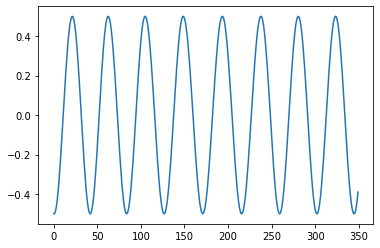

In [15]:
# choose a number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate

X_input_train = X_input_vali = X_input_test = np.empty((0, n_steps_in, 2))
y_output_train = y_output_vali = y_output_test = np.empty((0, n_steps_out, 2))

idx = list(range(len(list_str)))[::2] # for all dyads
# idx = [0] # testing with 1 dyad

for i in range(len(idx)):
        # define input sequence
        in_seq1 = data[idx[i]]
        in_seq2 = data[idx[i]+1]
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2))
        # covert into input/output
        X, y = split_sequences(dataset, n_steps_in, n_steps_out)
        # Data split
        num_train_samples = int(0.6 * len(X))
        num_val_samples = int(0.2 * len(X))
        num_test_samples = len(X) - num_train_samples - num_val_samples
        print("num_train_samples:", num_train_samples)
        print("num_val_samples:", num_val_samples)
        print("num_test_samples:", num_test_samples)

        X_input_train = np.append(X_input_train,X[:num_train_samples],axis=0)
        y_output_train = np.append(y_output_train,y[:num_train_samples],axis=0)
        X_input_vali = np.append(X_input_vali,X[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        y_output_vali = np.append(y_output_vali,y[num_train_samples:(num_train_samples+num_val_samples)],axis=0)
        X_input_test = np.append(X_input_test,X[(num_train_samples+num_val_samples):],axis=0)
        y_output_test = np.append(y_output_test,y[(num_train_samples+num_val_samples):],axis=0)

n_features = X.shape[2]

example = np.append(X_input_train[14,:,0], y_output_train[14,:,0])
example2 = np.append(X_input_train[14,:,1], y_output_train[14,:,1])
plt.plot(example)
# plt.plot(example2)
print(len(X_input_train), len(X_input_vali), len(X_input_test))

In [16]:
# define model (modified from Wieniawska 2020, https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]))
output_train = Input(shape=(y_output_train.shape[1], y_output_train.shape[2]))
print(input_train)
print(output_train)

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 250, 2), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/strided_slice_3:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name=None), name='time_dis

In [17]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.001, clipnorm=1)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 2)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 100),        41200       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 100)         400         ['lstm_2[0][0]']                 
 rmalization)                                                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
epc = 200
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train, y_output_train,  validation_data=(X_input_vali,y_output_vali), 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=64, shuffle=False)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/200
6/6 [==============================] - 10s 685ms/step - loss: 0.2531 - mae: 0.4056 - val_loss: 0.1281 - val_mae: 0.3207
Epoch 2/200
6/6 [==============================] - 3s 578ms/step - loss: 0.1565 - mae: 0.3396 - val_loss: 0.1324 - val_mae: 0.3228
Epoch 3/200
6/6 [==============================] - 4s 603ms/step - loss: 0.1414 - mae: 0.3281 - val_loss: 0.1278 - val_mae: 0.3170
Epoch 4/200
6/6 [==============================] - 4s 626ms/step - loss: 0.1342 - mae: 0.3220 - val_loss: 0.1234 - val_mae: 0.3138
Epoch 5/200
6/6 [==============================] - 4s 624ms/step - loss: 0.1294 - mae: 0.3174 - val_loss: 0.1204 - val_mae: 0.3097
Epoch 6/200
6/6 [==============================] - 4s 591ms/step - loss: 0.1262 - mae: 0.3136 - val_loss: 0.1186 - val_mae: 0.3069
Epoch 7/200
6/6 [==============================] - 4s 601ms/step - loss: 0.1241 - mae: 0.3108 - val_loss: 0.1177 - val_mae: 0.3054
Epoch 8/200
6/6 [==============================] - 4s 620ms/step - loss: 0.1216 - 

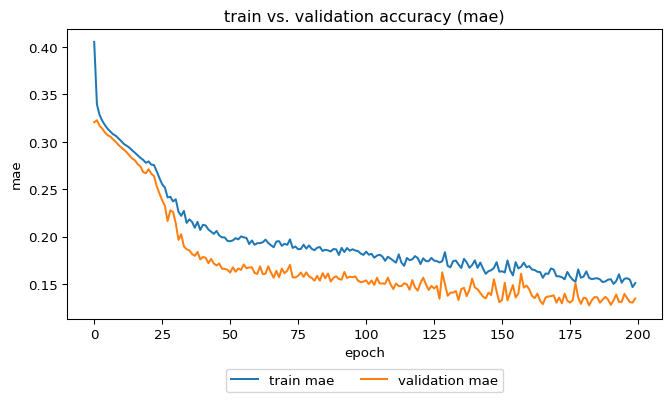

In [37]:
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [20]:
yhat_output_train = model.predict(X_input_train,batch_size=10)
yhat_output_test = model.predict(X_input_test,batch_size=10)

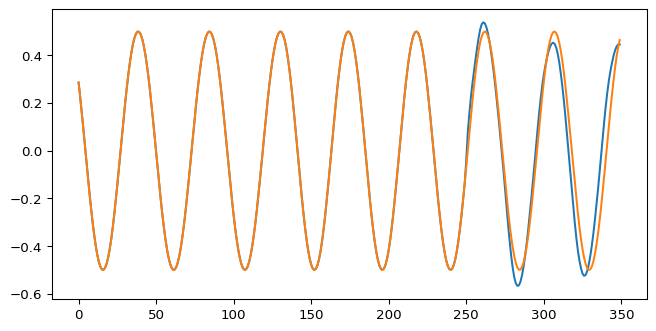

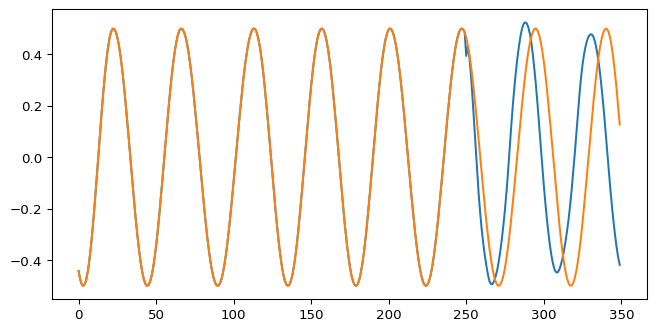

In [28]:
# model demonstration
trial = 64
person = 0

# demonstrate training

train_hat = np.append(X_input_train[trial,:,person],yhat_output_train[trial,:,person])
train = np.append(X_input_train[trial,:,person],y_output_train[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(1)
plt.plot(train_hat)
plt.plot(train)

# demonstrate prediction

test_hat = np.append(X_input_test[trial,:,person],yhat_output_test[trial,:,person])
test = np.append(X_input_test[trial,:,person],y_output_test[trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(2)

plt.plot(test_hat)
plt.plot(test)
# plt.plot(X_train[trial,:,person])
# plt.plot(X_train[trial,:,person])
# plt.plot(yhat_train[trial,:,person])

In [30]:
train_pred = model.predict(X_input_train)
test_pred = model.predict(X_input_test)
print(train_pred.shape, test_pred.shape)
train_true = y_output_train
test_true = y_output_test
print(train_true.shape, test_true.shape)

(348, 100, 2) (116, 100, 2)
(348, 100, 2) (116, 100, 2)


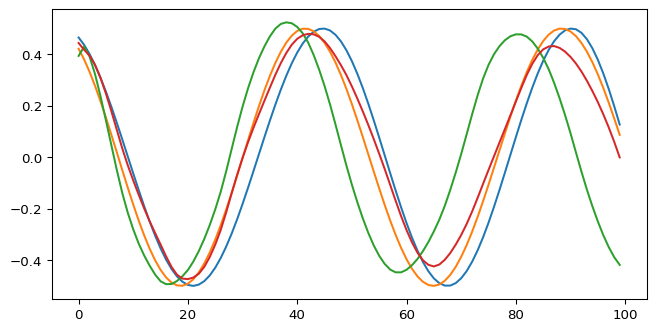

In [39]:
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(test_true[64])
plt.plot(test_pred[64])

In [32]:
data_final = {
  "train_pred": train_pred,
  "train_true": train_true,
  "test_pred": test_pred,
  "test_true": test_true
}

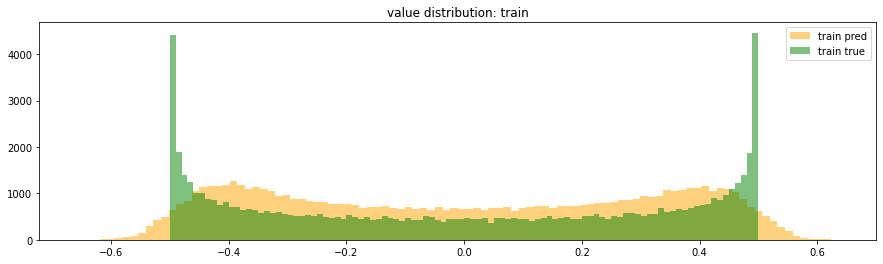

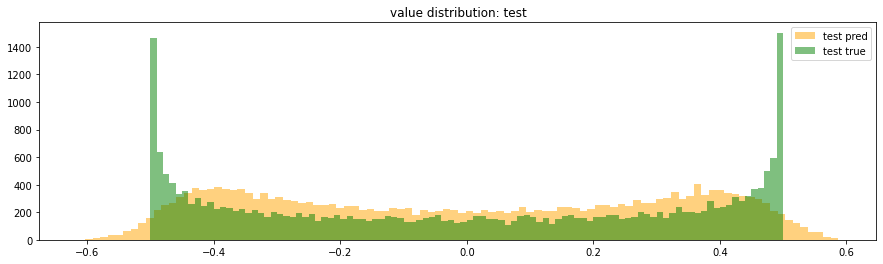

In [33]:

for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

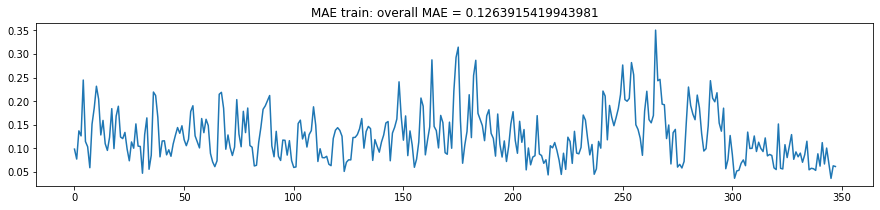

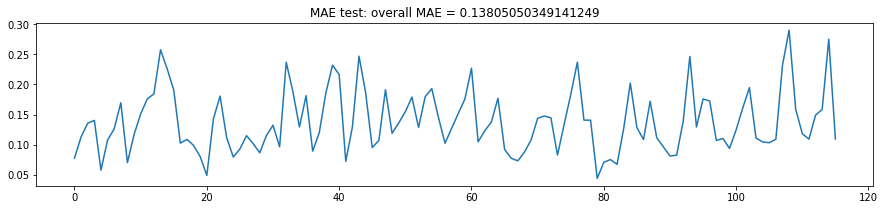

In [34]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

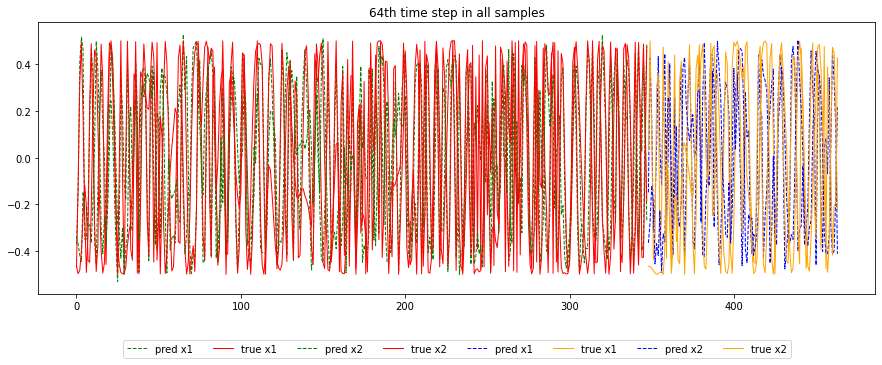

In [35]:

ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

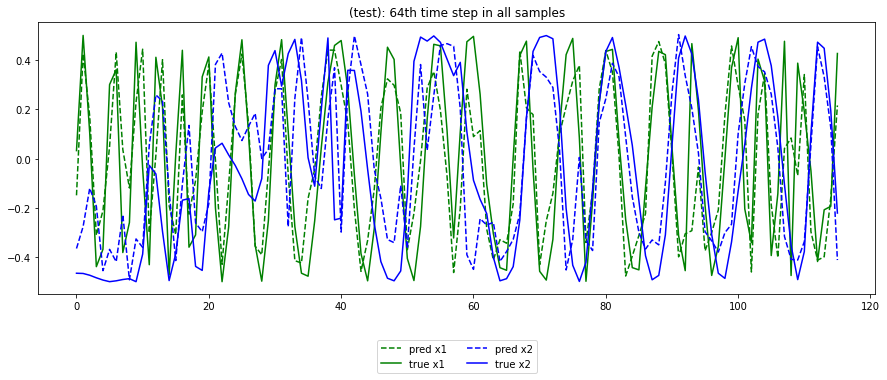

In [36]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()